# Setup

In [16]:
import transformer_lens
from samplers import generate_data, generate_data_with_p
import torch
from torch import optim
from tqdm import tqdm
import torch.nn as nn
from model import deactivate_position
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
from utils import get_log_resids_from_sequential_ones, get_theoretical_log, calculate_optimal_loss
import itertools
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [17]:
def prepend_bos(datasets, bos_token_value=2):
    """
    Prepend BOS token to each batch in the datasets.
    
    Args:
        datasets: List of torch tensors representing batches
        bos_token_value: Value of the BOS token (default: 2)
    
    Returns:
        List of modified tensors with BOS tokens prepended
    """
    modified_datasets = []
    for dataset in datasets:
        batch_size = dataset.shape[0]
        bos_tokens = torch.full((batch_size, 1), bos_token_value, dtype=torch.long)
        modified_dataset = torch.cat([bos_tokens, dataset], dim=1)
        modified_datasets.append(modified_dataset)
    return modified_datasets

In [18]:

def generate_all_binary_sequences_with_fixed_num_ones(n: int, num_ones: int, max_n_sequences: int = None, prepend_bos: bool = False, last_obs: int = None) -> torch.Tensor:
    """
    Generate all possible binary sequences of length n with exactly num_ones ones.
    If max_n_sequences is specified, only generate up to that many sequences.
    
    Args:
        n: Length of the sequence
        num_ones: Number of ones in each sequence
        max_n_sequences: Maximum number of sequences to generate (optional)
        prepend_bos: Whether to prepend BOS token (default: False)
        last_obs: If 0 or 1, fix the last token to this value (optional)
        
    Returns:
        torch.Tensor: Tensor of shape (num_permutations, n) or (num_permutations, n+1) if prepend_bos=True
    """
    if last_obs is not None and last_obs in [0, 1]:
        # If last token is fixed, we need to place ones in the first n-1 positions
        if last_obs == 1:
            # Last position is 1, so we need (num_ones - 1) ones in first (n-1) positions
            remaining_ones = num_ones - 1
        else:
            # Last position is 0, so we need num_ones ones in first (n-1) positions
            remaining_ones = num_ones
        
        # Check if it's possible to satisfy the constraint
        if remaining_ones < 0 or remaining_ones > (n - 1):
            return torch.empty((0, n), dtype=torch.long)
        
        # Generate combinations for the first n-1 positions
        positions_iter = itertools.combinations(range(n - 1), remaining_ones)
        if max_n_sequences is not None:
            positions_iter = itertools.islice(positions_iter, max_n_sequences)
        positions_list = list(positions_iter)
        num_permutations = len(positions_list)
        
        # Initialize the output tensor
        sequences = torch.zeros((num_permutations, n), dtype=torch.long)
        
        # Set the last position to the fixed value
        sequences[:, -1] = last_obs
        
        # Fill in the tensor with 1s at the appropriate positions in first n-1 positions
        for i, positions in enumerate(positions_list):
            for pos in positions:
                sequences[i, pos] = 1
    else:
        # Original behavior when last_obs is not specified or not 0/1
        positions_iter = itertools.combinations(range(n), num_ones)
        if max_n_sequences is not None:
            positions_iter = itertools.islice(positions_iter, max_n_sequences)
        positions_list = list(positions_iter)
        num_permutations = len(positions_list)
        
        # Initialize the output tensor
        sequences = torch.zeros((num_permutations, n), dtype=torch.long)
        
        # Fill in the tensor with 1s at the appropriate positions
        for i, positions in enumerate(positions_list):
            for pos in positions:
                sequences[i, pos] = 1
    
    # Prepend BOS token if requested
    if prepend_bos:
        bos_tokens = torch.full((num_permutations, 1), 2, dtype=torch.long)
        sequences = torch.cat([bos_tokens, sequences], dim=1)
    
    return sequences

In [19]:
def train_coinformer_model(model, 
                           num_epochs: int = 3,
                           learning_rate: float = 0.001,
                           batch_size: int = 64,
                           seq_length: int = 20,
                           num_batches: int = 100,
                           alpha_param: float = 1.0,
                           beta_param: float = 1.0,
                           bernoulli: bool = False,
                           bernoulli_p: float = 0.5,
                           flip_batch: bool = False,
                           pos_embed: bool = True,
                           add_zeros_and_ones: int = 0,
                           scale: float = 1.0,
                           bias: float = 0.0,
                           importance_sampling: bool = False,
                           importance_sampling_alpha: float = 1.0,
                           importance_sampling_beta: float = 1.0):
    """Train the Coinformer model."""
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    losses = []

    # Deactivate positional embedding if specified
    if not pos_embed:
        model = deactivate_position(model)
    else:
        # Ensure positional embedding gradients are enabled when pos_embed=True
        for name, param in model.named_parameters():
            if "pos_embed" in name or "W_pos" in name:
                param.requires_grad = True
    

    for epoch in range(num_epochs):
        # Generate new data for each epoch
        datasets, priors = generate_data(batch_size=batch_size, seq_length=seq_length, 
                                   num_batches=num_batches, alpha=alpha_param, beta=beta_param, bernoulli=bernoulli, bernoulli_p=bernoulli_p, flip_batch=flip_batch
                                   , scale=scale, bias=bias)

        # Prepend BOS token to each batch
        datasets = prepend_bos(datasets)

        # Add the specified number of batches of all 0s and all 1s
        if add_zeros_and_ones > 0:
            zeros_ones_batches = []
            for _ in range(add_zeros_and_ones):
                zeros = torch.zeros((batch_size, seq_length), dtype=torch.long)
                ones = torch.ones((batch_size, seq_length), dtype=torch.long)
                zeros_ones_batches.extend([zeros, ones])
                priors.extend([0.0, 1.0])
            
            # Prepend BOS tokens to the newly added batches and extend datasets
            zeros_ones_with_bos = prepend_bos(zeros_ones_batches)
            datasets.extend(zeros_ones_with_bos)

        epoch_loss = 0
        
        # Plot histogram of priors for this epoch
        # plt.figure(figsize=(8, 4))
        # plt.hist(priors, bins=10, alpha=0.7, color='blue', edgecolor='black')
        # plt.title(f'Distribution of Prior Probabilities (Epoch {epoch+1})')
        # plt.xlabel('Probability Value')
        # plt.ylabel('Frequency')
        # plt.grid(True, alpha=0.3)
        # plt.show()
        if importance_sampling:
            optimal_loss = calculate_optimal_loss(importance_sampling_alpha, importance_sampling_beta)
        else:
            optimal_loss = calculate_optimal_loss(alpha_param, beta_param)

        for data_batch, prior in tqdm(zip(datasets, priors), desc=f"Epoch {epoch+1}/{num_epochs}"):
            data_batch = data_batch.to(DEVICE)
            # For each sequence, use all tokens except the last one as input
            inputs = data_batch[:, :-1]
            # Use all tokens except the first one as targets
            targets = data_batch[:, 1:]
            
            # Forward pass
            logits = model(inputs)
            
            # Reshape logits and targets for loss calculation
            logits_view = logits.view(-1, model.cfg.d_vocab)
            targets_view = targets.reshape(-1)
            
            # Calculate loss
            loss = criterion(logits_view, targets_view)
            if importance_sampling:
                weights = beta(importance_sampling_alpha, importance_sampling_beta).pdf(prior)
                loss = loss * weights

            epoch_loss += loss.item()
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_loss = epoch_loss / len(datasets)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Theoretical Loss Lower Bound: {optimal_loss:.4f}")

        # # After each epoch, analyze model's behavior on sequences with a single 1
        # model.eval()  # Set model to evaluation mode
        # with torch.no_grad():  # Disable gradient computation
        #     print(f"\\nAnalyzing model behavior after epoch {epoch+1}:")
        #     analyze_single_one_sequences(model, seq_length=20)
        # model.train()  # Set model back to training mode

    return losses

In [20]:

def generate_tokens(model, input_tokens, max_new_tokens=10, do_sample=True, temperature=1.0, num_samples=1):
    """
    Generate tokens from the model without requiring a tokenizer.
    
    Args:
        model: The transformer model
        input_tokens: Starting tokens as a tensor of shape [batch_size, seq_len]
        max_new_tokens: Maximum number of new tokens to generate
        do_sample: Whether to sample from the distribution (True) or use greedy decoding (False)
        temperature: Temperature for sampling (higher = more random)
        num_samples: Number of samples to generate for each input sequence
    
    Returns:
        Generated sequence including the input tokens, shape [batch_size * num_samples, seq_len + max_new_tokens]
    """
    model.eval()
    
    with torch.no_grad():
        # Repeat input tokens for each sample
        current_tokens = input_tokens.repeat_interleave(num_samples, dim=0)
        
        for _ in range(max_new_tokens):
            # Get model predictions
            logits = model(current_tokens)
            
            # Get the logits for the last position
            next_token_logits = logits[:, -1, :] / temperature
            
            if do_sample:
                # Sample from the probability distribution
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy decoding - take the most likely token
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            
            # Append the new token to the sequence
            current_tokens = torch.cat([current_tokens, next_token], dim=1)
            
            # Stop if we hit the context limit
            if current_tokens.shape[1] >= model.cfg.n_ctx:
                break
    
    return current_tokens




def predictive_resampling(model: transformer_lens.HookedTransformer,
    prefix: torch.Tensor = None,
    num_samples: int = 1000,
    M: int = 50,
    device: str = 'cpu',
    max_seq_length: int = 50
):
    """
    Perform predictive resampling using the Transformer model.
    
    Args:
        model: The Transformer model to use for resampling.
        prefix: Optional prefix tensor to condition the model on. If None, starts with BOS token (2).
        num_samples: Number of samples to generate.
        M: Number of samples per batch.
        device: Device to run the model on ('cpu' or 'cuda').
        max_seq_length: Maximum length of generated sequences.
    
    Returns:
        A tensor of probabilities for token 1, shape (num_samples,).
    """
    model.to(device).eval()
    
    # Set default prefix to BOS token if none provided
    if prefix is None:
        prefix = torch.tensor([[2]], device=device)
    else:
        prefix = prefix.to(device)
    
    # Generate samples
    all_probs = []
    num_batches = (num_samples + M - 1) // M  # Ceiling division
    
    for i in range(num_batches):
        current_batch_size = min(M, num_samples - i * M)
        
        # Create batch by repeating the prefix
        batch_prefix = prefix.repeat(current_batch_size, 1)
        
        # Generate sequences for this batch
        batch_sequences = generate_tokens(
            model, 
            batch_prefix, 
            max_new_tokens=max_seq_length - prefix.shape[1], 
            do_sample=True
        )
        
        # Compute logits and extract probability of token 1
        with torch.no_grad():
            logits = model(batch_sequences)
            probs = torch.softmax(logits, dim=-1)
            # Extract probability of token 1 from the last position
            prob_token_1 = probs[:, -1, 1]  # Shape: (batch_size,)
            all_probs.append(prob_token_1.cpu())
    
    return torch.cat(all_probs, dim=0)[:num_samples]


def compare_priors(
    A,
    B,
    model: transformer_lens.HookedTransformer,
    device: str = 'cpu',
    n_samples: int = 1000,
):
    
    """
    Based on the PUQ framework by Fortini and Petrone et al.
    """

    print(f"→ Starting compare_priors on device='{device}'.")

    model.to(device).eval()

    # Build a uniform grid on [0,1] and compute true prior density of P(A)
    grid = np.linspace(0, 1, 300)
    true_prior = beta(A, B).pdf(grid)

    plt.figure(figsize=(8, 5))

    # Plot true prior
    plt.plot(
        grid,
        true_prior,
        label='True Prior',
        lw=2
    )

    # Generate prior samples via Transformer predictive resampling (prefix=None)
    t1 = time.time()
    prior_samples = predictive_resampling(
        model,
        prefix=None,
        num_samples=n_samples,
        M=50,
        device=device
    ).cpu().numpy()
    print(f"  Transformer predictive resampling for prior in {time.time() - t1:.3f} sec.")

    # Overlay histogram of resampled prior P(A)
    # Use fewer bins for better visual comparison with the PDF
    n_bins = 50
    plt.hist(
        prior_samples,
        bins=n_bins,
        density=True,
        alpha=0.6,
        range=(0, 1),  # Ensure histogram covers the same range as the PDF
        label='Transformer Predictive Resampling'
    )

    # Use simple title and xlabel
    plt.title('Prior distribution comparison')
    plt.xlabel('P(A)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# Training

In [21]:
coinformer_wit_bos_config = transformer_lens.HookedTransformerConfig(
    d_model=64, #embedding dimension
    d_head=64,
    n_layers=1,
    n_ctx=100,
    d_vocab=3,
    act_fn="relu",
    default_prepend_bos=False,  # Disable automatic BOS prepending since we do it manually
    normalization_type=None,
)

model = transformer_lens.HookedTransformer(coinformer_wit_bos_config).to(DEVICE)

Moving model to device:  mps


In [22]:
losses = train_coinformer_model(model,
                                num_epochs=5,
                                learning_rate=0.001,
                                batch_size=64,
                                seq_length=99,
                                num_batches=1000,
                                alpha_param=1.0,
                                beta_param=1.0,
                                pos_embed=True
                                )

Probability range: [0.002, 1.000]


Epoch 1/5: 1000it [00:11, 90.27it/s]


Epoch 1, Loss: 0.5405, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.000, 0.999]


Epoch 2/5: 1000it [00:10, 95.81it/s]


Epoch 2, Loss: 0.5114, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.000, 0.999]


Epoch 3/5: 1000it [00:10, 95.13it/s]


Epoch 3, Loss: 0.5172, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.001, 0.998]


Epoch 4/5: 1000it [00:10, 95.76it/s]


Epoch 4, Loss: 0.5290, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.000, 1.000]


Epoch 5/5: 1000it [00:10, 96.56it/s]


Epoch 5, Loss: 0.5136, Theoretical Loss Lower Bound: 0.5000


# Diagnostics

In [23]:
# Test the generation function with multiple samples
generated_sequences = generate_tokens(model, torch.tensor([[2]]).to(DEVICE), max_new_tokens=10, do_sample=True, num_samples=5)
print(f"Generated sequences shape: {generated_sequences.shape}")
for i, seq in enumerate(generated_sequences):
    print(f"Sample {i+1}: {seq[1:].tolist()}")  # Exclude BOS token

Generated sequences shape: torch.Size([5, 11])
Sample 1: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Sample 2: [0, 1, 1, 1, 1, 1, 0, 0, 1, 0]
Sample 3: [0, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Sample 4: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Sample 5: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


→ Starting compare_priors on device='mps'.
Moving model to device:  mps
Moving model to device:  mps
  Transformer predictive resampling for prior in 11.280 sec.


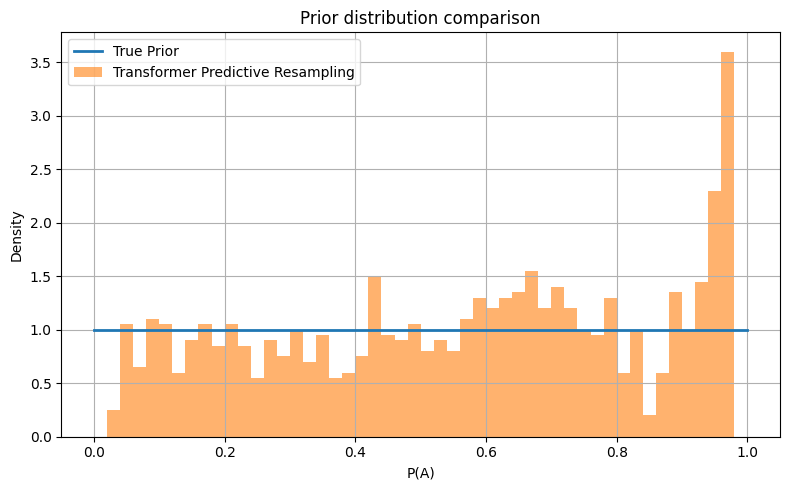

In [31]:
compare_priors(
    A= 1.0,
    B= 1.0,
    model= model,
    device= DEVICE,
    n_samples= 1000
)

## Compare this with a transformer that does not have positional embeddings

Moving model to device:  mps
Probability range: [0.001, 1.000]


Epoch 1/5: 1000it [00:10, 92.78it/s]


Epoch 1, Loss: 0.5263, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.002, 1.000]


Epoch 2/5: 1000it [00:10, 94.30it/s]


Epoch 2, Loss: 0.5255, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.001, 0.999]


Epoch 3/5: 1000it [00:10, 95.29it/s]


Epoch 3, Loss: 0.5245, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.000, 1.000]


Epoch 4/5: 1000it [00:10, 94.65it/s]


Epoch 4, Loss: 0.5229, Theoretical Loss Lower Bound: 0.5000
Probability range: [0.001, 0.999]


Epoch 5/5: 1000it [00:10, 92.23it/s]


Epoch 5, Loss: 0.5073, Theoretical Loss Lower Bound: 0.5000
→ Starting compare_priors on device='mps'.
Moving model to device:  mps
Moving model to device:  mps
  Transformer predictive resampling for prior in 10.869 sec.


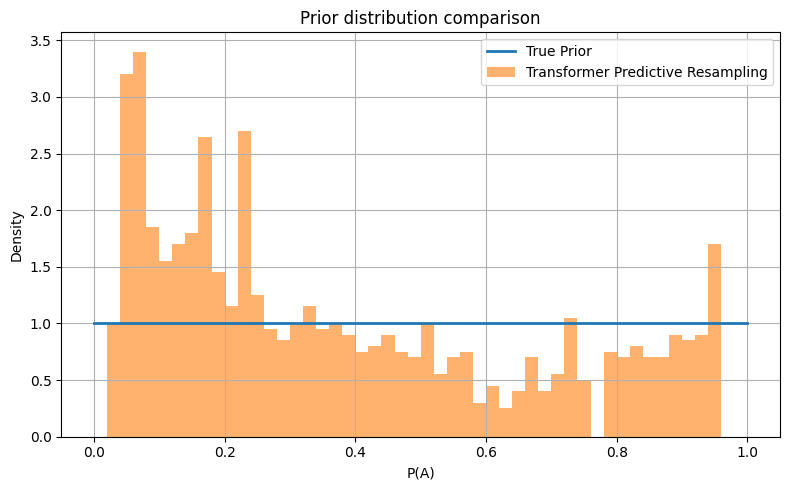

In [25]:
model2 = transformer_lens.HookedTransformer(coinformer_wit_bos_config).to(DEVICE)
losses2 = train_coinformer_model(model2,
                                  num_epochs=5,
                                  learning_rate=0.001,
                                  batch_size=64,
                                  seq_length=99,
                                  num_batches=1000,
                                  alpha_param=1.0,
                                  beta_param=1.0,
                                  pos_embed=False
                                  )

compare_priors(
    A= 1.0,
    B= 1.0,
    model= model2,
    device= DEVICE,
    n_samples= 1000
)

# Residual Stream Experiments

We first look at a sequences of length 10 with 5 ones and 5 zeros, where the last token is fixed to be 1. 

In [40]:
sample = generate_all_binary_sequences_with_fixed_num_ones(
    n=99, 
    num_ones=50, 
    max_n_sequences=256, 
    prepend_bos=True, 
    last_obs=1  # Fix the last token to 1
)

sample

tensor([[2, 1, 1,  ..., 0, 0, 1],
        [2, 1, 1,  ..., 0, 0, 1],
        [2, 1, 1,  ..., 0, 0, 1],
        ...,
        [2, 1, 1,  ..., 0, 0, 1],
        [2, 1, 1,  ..., 0, 0, 1],
        [2, 1, 1,  ..., 0, 0, 1]])

In [41]:
with torch.inference_mode():
    logits, cache = model.run_with_cache(sample)

resids = cache["resid_mid", -1][:, -1, :]  ## we focus on resid_mid, which is the residual stream after the attention layer but before the mlp

# the idea is that the attention layer encodes the sufficient statistics, and the mlp simply learns the nonlinear operation of converting into logits

print(f"Residuals shape: {resids.shape}") # (batch_size, d_model)
print("Cache keys:", list(cache.keys()))

Residuals shape: torch.Size([256, 64])
Cache keys: ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post']


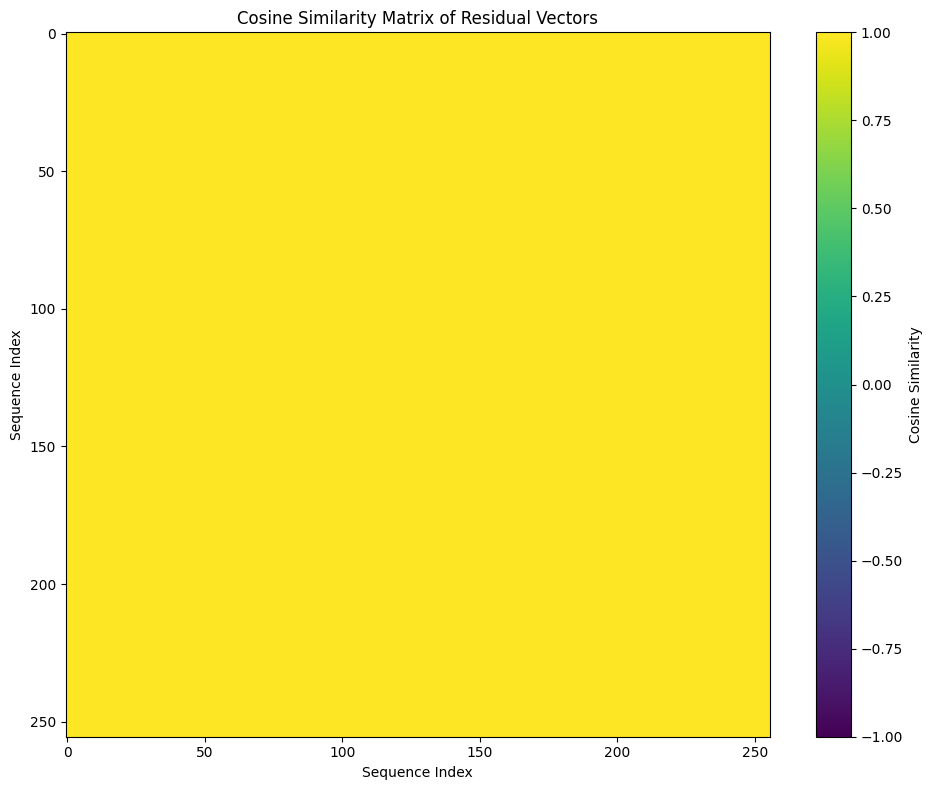

tensor([[ 0.1507, -0.0903,  0.0429,  ..., -0.1140,  0.1098, -0.4510],
        [ 0.1508, -0.0898,  0.0433,  ..., -0.1140,  0.1101, -0.4509],
        [ 0.1505, -0.0902,  0.0430,  ..., -0.1132,  0.1099, -0.4505],
        ...,
        [ 0.1515, -0.0913,  0.0427,  ..., -0.1136,  0.1100, -0.4518],
        [ 0.1511, -0.0910,  0.0431,  ..., -0.1133,  0.1103, -0.4512],
        [ 0.1511, -0.0908,  0.0434,  ..., -0.1131,  0.1103, -0.4524]],
       device='mps:0')

In [42]:
cosine_sim_matrix = sklearn_cosine_similarity(resids.cpu().numpy())

# Plot the cosine similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(cosine_sim_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Matrix of Residual Vectors')
plt.xlabel('Sequence Index')
plt.ylabel('Sequence Index')
plt.tight_layout()
plt.show()

resids

# Attention Head Visualisation

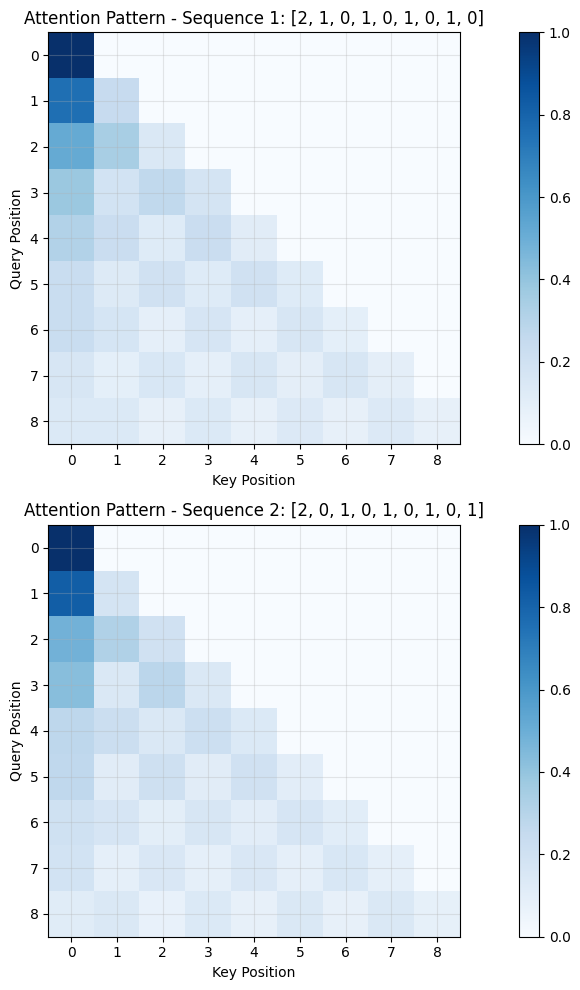

In [30]:

seq1 = torch.tensor([2] + [1,0]* 4)
seq2 = torch.tensor([2] + [0,1]* 4)
# Visualize attention for seq1 and seq2
sequences = torch.stack([seq1, seq2]).to(DEVICE)

with torch.inference_mode():
    logits, cache = model.run_with_cache(sequences)

# Get attention patterns
attention_patterns = cache["pattern", 0]  # Shape: [batch, n_heads, seq_len, seq_len]

# Create visualization for both sequences
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for seq_idx in range(2):
    # Get attention pattern for this sequence (assuming single head)
    attn_pattern = attention_patterns[seq_idx, 0].cpu().numpy()  # Shape: [seq_len, seq_len]
    
    im = axes[seq_idx].imshow(attn_pattern, cmap='Blues', vmin=0, vmax=1)
    axes[seq_idx].set_title(f'Attention Pattern - Sequence {seq_idx + 1}: {sequences[seq_idx].tolist()}')
    axes[seq_idx].set_xlabel('Key Position')
    axes[seq_idx].set_ylabel('Query Position')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[seq_idx])
    
    # Add grid
    axes[seq_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Fitting Residual to a function of N and H

In [53]:
import torch

batch_size = 100  # Number of rows
seq_length = 100  # Total length (including the first column of 2s)

# Initialize the tensor with zeros
tensor = torch.zeros((batch_size, seq_length), dtype=torch.long)

# Set the first column to 2 (BOS token)
tensor[:, 0] = 2

# Fill a lower‐triangular band of 1’s (including the diagonal) starting at column 1
for i in range(1, min(batch_size, seq_length)):
    tensor[i, 1 : i+1] = 1



In [56]:
logits, cache = model.run_with_cache(tensor)

resids = cache["resid_mid", -1]

In [57]:
resids.shape

torch.Size([100, 100, 64])

In [67]:
mask2d = torch.triu(torch.ones((batch_size, seq_length), dtype=torch.bool), diagonal=0)
mask2d

relevant_resids = resids[mask2d]


In [79]:
N_obs = torch.zeros_like(tensor)

for i in range(seq_length):
    N_obs[:, i] = i

N_obs

relevant_N = N_obs[mask2d]

In [80]:
H_obs = tensor.clone()

H_obs[:,0] = 0

for i in range(1, batch_size):
    H_obs[i, : ] = torch.cumsum(tensor[i, :], dim=0) -2

H_obs

relevant_H = H_obs[mask2d]

In [81]:
print(relevant_resids.shape)
print(relevant_N.shape)
print(relevant_H.shape)

torch.Size([5050, 64])
torch.Size([5050])
torch.Size([5050])


Epoch 1/30: 100%|██████████| 20/20 [00:00<00:00, 60.31it/s]


Epoch 1, Loss: 3.783417


Epoch 2/30: 100%|██████████| 20/20 [00:00<00:00, 381.41it/s]


Epoch 2, Loss: 0.215022


Epoch 3/30: 100%|██████████| 20/20 [00:00<00:00, 412.36it/s]


Epoch 3, Loss: 0.059559


Epoch 4/30: 100%|██████████| 20/20 [00:00<00:00, 391.55it/s]


Epoch 4, Loss: 0.033854


Epoch 5/30: 100%|██████████| 20/20 [00:00<00:00, 157.48it/s]


Epoch 5, Loss: 0.024435


Epoch 6/30: 100%|██████████| 20/20 [00:00<00:00, 419.01it/s]


Epoch 6, Loss: 0.021289


Epoch 7/30: 100%|██████████| 20/20 [00:00<00:00, 442.60it/s]


Epoch 7, Loss: 0.019952


Epoch 8/30: 100%|██████████| 20/20 [00:00<00:00, 430.18it/s]


Epoch 8, Loss: 0.019091


Epoch 9/30: 100%|██████████| 20/20 [00:00<00:00, 366.00it/s]


Epoch 9, Loss: 0.018711


Epoch 10/30: 100%|██████████| 20/20 [00:00<00:00, 353.04it/s]


Epoch 10, Loss: 0.018081


Epoch 11/30: 100%|██████████| 20/20 [00:00<00:00, 372.21it/s]


Epoch 11, Loss: 0.017620


Epoch 12/30: 100%|██████████| 20/20 [00:00<00:00, 399.26it/s]


Epoch 12, Loss: 0.017289


Epoch 13/30: 100%|██████████| 20/20 [00:00<00:00, 474.73it/s]


Epoch 13, Loss: 0.016561


Epoch 14/30: 100%|██████████| 20/20 [00:00<00:00, 474.09it/s]


Epoch 14, Loss: 0.015956


Epoch 15/30: 100%|██████████| 20/20 [00:00<00:00, 460.65it/s]


Epoch 15, Loss: 0.015103


Epoch 16/30: 100%|██████████| 20/20 [00:00<00:00, 429.10it/s]


Epoch 16, Loss: 0.014682


Epoch 17/30: 100%|██████████| 20/20 [00:00<00:00, 428.42it/s]


Epoch 17, Loss: 0.014024


Epoch 18/30: 100%|██████████| 20/20 [00:00<00:00, 471.69it/s]


Epoch 18, Loss: 0.013823


Epoch 19/30: 100%|██████████| 20/20 [00:00<00:00, 437.61it/s]


Epoch 19, Loss: 0.013180


Epoch 20/30: 100%|██████████| 20/20 [00:00<00:00, 169.79it/s]


Epoch 20, Loss: 0.012504


Epoch 21/30: 100%|██████████| 20/20 [00:00<00:00, 456.58it/s]


Epoch 21, Loss: 0.011898


Epoch 22/30: 100%|██████████| 20/20 [00:00<00:00, 468.84it/s]


Epoch 22, Loss: 0.011445


Epoch 23/30: 100%|██████████| 20/20 [00:00<00:00, 487.71it/s]


Epoch 23, Loss: 0.010990


Epoch 24/30: 100%|██████████| 20/20 [00:00<00:00, 455.68it/s]


Epoch 24, Loss: 0.010496


Epoch 25/30: 100%|██████████| 20/20 [00:00<00:00, 471.06it/s]


Epoch 25, Loss: 0.010147


Epoch 26/30: 100%|██████████| 20/20 [00:00<00:00, 462.18it/s]


Epoch 26, Loss: 0.009898


Epoch 27/30: 100%|██████████| 20/20 [00:00<00:00, 464.61it/s]


Epoch 27, Loss: 0.009628


Epoch 28/30: 100%|██████████| 20/20 [00:00<00:00, 463.58it/s]


Epoch 28, Loss: 0.009710


Epoch 29/30: 100%|██████████| 20/20 [00:00<00:00, 448.18it/s]


Epoch 29, Loss: 0.009701


Epoch 30/30: 100%|██████████| 20/20 [00:00<00:00, 405.20it/s]


Epoch 30, Loss: 0.009456


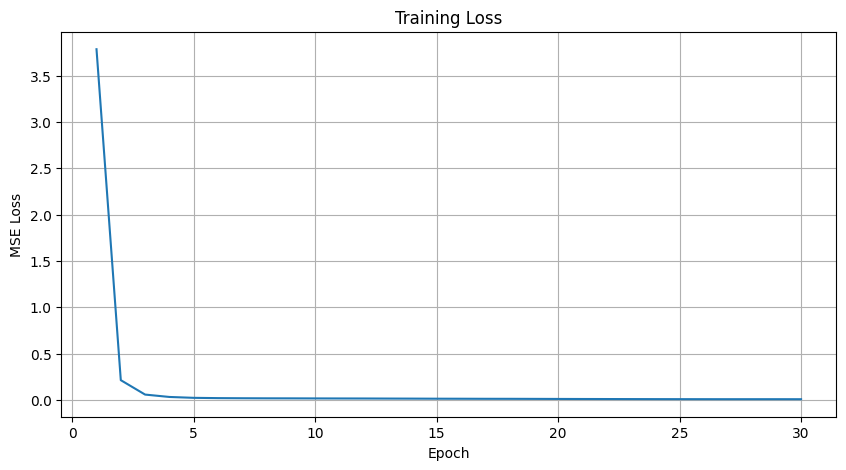

Input: N=67.0, H=2.0
Target: tensor([0.1543, 0.2299, 0.2964, 0.0175, 0.0503], device='mps:0')
Prediction: tensor([0.1650, 0.2369, 0.2100, 0.1124, 0.0513], device='mps:0')

Input: N=90.0, H=58.0
Target: tensor([ 0.3433, -0.3583,  0.0667, -0.2629,  0.0565], device='mps:0')
Prediction: tensor([ 0.2212, -0.4572, -0.0622, -0.2681,  0.0949], device='mps:0')

Input: N=6.0, H=3.0
Target: tensor([ 0.1718, -0.4393,  0.1050, -0.3182,  0.0117], device='mps:0')
Prediction: tensor([ 0.1258, -0.2754,  0.0921, -0.2521,  0.1884], device='mps:0')

Input: N=87.0, H=65.0
Target: tensor([ 0.1152, -0.4585, -0.0592, -0.1375,  0.0403], device='mps:0')
Prediction: tensor([ 0.2579, -0.5581, -0.0649, -0.3244,  0.0991], device='mps:0')

Input: N=29.0, H=24.0
Target: tensor([ 0.2167, -0.5616, -0.0879, -0.2577,  0.1766], device='mps:0')
Prediction: tensor([ 0.2154, -0.5034,  0.0033, -0.3952,  0.1052], device='mps:0')



In [83]:
import torch
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=64):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

# Prepare data
# Move tensors to same device and convert to float
N = relevant_N.float().to(DEVICE)
H = relevant_H.float().to(DEVICE)
targets = relevant_resids.to(DEVICE)

# Create input tensor
X = torch.stack([N, H], dim=1)  # Shape: [num_samples, 2]

# Create and train the model
mlp = MLP(input_dim=2, hidden_dim=128, output_dim=64).to(DEVICE)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 30
batch_size = 256

# Create DataLoader
indices = torch.randperm(X.size(0))
X = X[indices]
targets = targets[indices]

# Training loop
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = (X.size(0) + batch_size - 1) // batch_size  # Ceiling division
    
    for i in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, X.size(0))
        
        batch_X = X[start_idx:end_idx]
        batch_targets = targets[start_idx:end_idx]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = mlp(batch_X)
        
        # Calculate loss
        loss = criterion(outputs, batch_targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * (end_idx - start_idx)
    
    avg_epoch_loss = epoch_loss / X.size(0)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.6f}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# Test the model
with torch.no_grad():
    # Sample a few points to compare predictions with actual values
    sample_indices = torch.randint(0, X.size(0), (5,))
    sample_X = X[sample_indices]
    sample_targets = targets[sample_indices]
    
    predictions = mlp(sample_X)
    
    for i in range(5):
        print(f"Input: N={sample_X[i][0].item():.1f}, H={sample_X[i][1].item():.1f}")
        print(f"Target: {sample_targets[i][:5]}")
        print(f"Prediction: {predictions[i][:5]}")
        print() 